# LDA with Gensim

DS 5001 Text as Data

**Purpose:** Using Gensim to generate topic models.

# Set Up

## Config

In [1]:
import configparser
config = configparser.ConfigParser()
config.read('../../../env.ini')
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']
local_lib = config['DEFAULT']['local_lib']

In [2]:
data_prefix = 'austen-melville'

## Imports

In [3]:
import pandas as pd
import numpy as np
from gensim.corpora import Dictionary
from gensim.models import LdaModel

# Get Data

In [5]:
TOKENS = pd.read_csv(f"{output_dir}/{data_prefix}-CORPUS.csv")
OHCO = list(TOKENS.columns[:5])
TOKENS = TOKENS.set_index(OHCO)

# Create Gensum Corpus

We convert our TOKENS table into Gensim data structures.

Gensim uses lists and dictionaries wrapped in objects to provide various kinds of access.

Note that this is a bit of reinventing the wheel and it's not faster than what we've been doing with Pandas.

In [6]:
TOKENS['pos_group'] = TOKENS.pos.str[:2]

In [7]:
CORPUS = TOKENS[TOKENS.pos_group.str.contains('NN|VB') & ~TOKENS.pos.str.contains('NNP')]

In [8]:
DOCS = CORPUS.dropna().groupby(OHCO[:3]).term_str.apply(list)

In [9]:
DOCS

book_id  chap_id  para_num
105      1        1           [was, man, who, amusement, took, book, found, ...
                  2                                                    [elliot]
                  3           [walter, born, married, daughter, county, lady...
                  4           [had, paragraph, stood, printers, hands, had, ...
                  5           [followed, history, rise, ancient, family, ter...
                                                    ...                        
34970    114      18          [yes, dead, plumage, hides, it, carrion, is, w...
                  19          [dark, veins, burst, heres, deluge, wreck, str...
                  20          [oer, ye, know, came, gasping, wall, fingers, ...
                  21                                                    [finis]
                  24                                                      [end]
Name: term_str, Length: 29897, dtype: object

In [10]:
vocab = Dictionary(DOCS.tolist()) 
vocab.filter_extremes(no_below=20, no_above=0.5)
corpus = [vocab.doc2bow(doc) for doc in DOCS.tolist()]

# Generate LDA

Next, we train a model using Gensim's LDA topic modeler.

We set some training parameters.

Regarding these, here are some notes from the Gensim site:

> First of all, the elephant in the room: how many topics do I need? There is
really no easy answer for this, it will depend on both your data and your
application. I have used 10 topics here because I wanted to have a few topics
that I could interpret and "label", and because that turned out to give me
reasonably good results. You might not need to interpret all your topics, so
you could use a large number of topics, for example 100.

> ``chunksize`` controls how many documents are processed at a time in the
training algorithm. Increasing chunksize will speed up training, at least as
long as the chunk of documents easily fit into memory. I've set ``chunksize =
2000``, which is more than the amount of documents, so I process all the
data in one go. Chunksize can however influence the quality of the model, as
discussed in Hoffman and co-authors [2], but the difference was not
substantial in this case.

> ``passes`` controls how often we train the model on the entire corpus.
Another word for passes might be "epochs". ``iterations`` is somewhat
technical, but essentially it controls how often we repeat a particular loop
over each document. It is important to set the number of "passes" and
"iterations" high enough.

> I suggest the following way to choose iterations and passes. First, enable
logging (as described in many Gensim tutorials), and set ``eval_every = 1``
in ``LdaModel``. When training the model look for a line in the log that
looks something like this::

>```2016-06-21 15:40:06,753 - gensim.models.ldamodel - DEBUG - 68/1566 documents converged within 400 iterations```

> If you set ``passes = 20`` you will see this line 20 times. Make sure that by
the final passes, most of the documents have converged. So you want to choose
both passes and iterations to be high enough for this to happen.

> We set ``alpha = 'auto'`` and ``eta = 'auto'``. Again this is somewhat
technical, but essentially we are automatically learning two parameters in
the model that we usually would have to specify explicitly.




In [11]:
num_topics = 40
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

We also make an index to word dictionary, since the model wants it.

In [12]:
temp = vocab[0]  # This is only to "load" the dictionary.
id2word = vocab.id2token

In [13]:
model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

# Inspect Results

In [14]:
PHI_gs = pd.DataFrame(model.get_topics(), columns=[v[1] for v in vocab.items()])

In [15]:
THETA_gs = pd.DataFrame([(i, t[0], t[1]) 
    for i, d in enumerate(model.get_document_topics(corpus)) 
    for t in d],
    columns=['doc_id', 'topic_id', 'topic_weight'])\
    .set_index(['doc_id','topic_id'])\
    .unstack(fill_value=0)
THETA_gs.index = DOCS.index
THETA_gs.columns = THETA_gs.columns.droplevel(0)

In [16]:
THETA_gs

topic_id                   0         1         2         3         4   \
book_id chap_id para_num                                                
105     1       1         0.0  0.000000  0.000000  0.000000  0.079203   
                2         0.0  0.010810  0.014584  0.010313  0.000000   
                3         0.0  0.053364  0.010898  0.000000  0.000000   
                4         0.0  0.065025  0.000000  0.000000  0.000000   
                5         0.0  0.023862  0.000000  0.000000  0.000000   
...                       ...       ...       ...       ...       ...   
34970   114     18        0.0  0.000000  0.011705  0.000000  0.000000   
                19        0.0  0.000000  0.027546  0.000000  0.042374   
                20        0.0  0.000000  0.029767  0.026964  0.000000   
                21        0.0  0.010810  0.014584  0.010313  0.000000   
                24        0.0  0.010487  0.014149  0.010005  0.000000   

topic_id                        5         6         7         8         9   \
book_id chap_id para_num                                                     
105     1       1         0.000000  0.000000  0.000000  0.019418  0.025296   
                2         0.010738  0.010867  0.012071  0.000000  0.021044   
                3         0.122911  0.000000  0.000000  0.000000  0.015726   
                4         0.000000  0.000000  0.000000  0.000000  0.032695   
                5         0.000000  0.041277  0.000000  0.000000  0.012111   
...                            ...       ...       ...       ...       ...   
34970   114     18        0.000000  0.000000  0.000000  0.000000  0.041567   
                19        0.000000  0.000000  0.026018  0.024148  0.031470   
                20        0.000000  0.000000  0.000000  0.000000  0.034012   
                21        0.010738  0.010867  0.012071  0.000000  0.021044   
                24        0.010417  0.010543  0.011711  0.000000  0.020416   

topic_id                  ...        30        31        32        33  \
book_id chap_id para_num  ...                                           
105     1       1         ...  0.044298  0.020108  0.000000  0.037095   
                2         ...  0.090208  0.010382  0.010087  0.044412   
                3         ...  0.067412  0.000000  0.000000  0.033444   
                4         ...  0.056949  0.000000  0.000000  0.047448   
                5         ...  0.051916  0.000000  0.000000  0.025924   
...                       ...       ...       ...       ...       ...   
34970   114     18        ...  0.089044  0.000000  0.000000  0.060321   
                19        ...  0.067437  0.000000  0.000000  0.064352   
                20        ...  0.081881  0.000000  0.026816  0.111139   
                21        ...  0.090208  0.010382  0.010087  0.044412   
                24        ...  0.087517  0.010072  0.000000  0.056689   

topic_id                        34        35        36        37        38  \
book_id chap_id para_num                                                     
105     1       1         0.000000  0.016604  0.000000  0.336537  0.000000   
                2         0.011697  0.033945  0.000000  0.322015  0.013823   
                3         0.000000  0.025367  0.000000  0.286320  0.010330   
                4         0.000000  0.021430  0.044342  0.339119  0.000000   
                5         0.024424  0.054892  0.000000  0.309164  0.000000   
...                            ...       ...       ...       ...       ...   
34970   114     18        0.000000  0.051906  0.000000  0.291002  0.011094   
                19        0.000000  0.057963  0.000000  0.239134  0.000000   
                20        0.000000  0.042480  0.000000  0.308651  0.000000   
                21        0.011697  0.033945  0.000000  0.322015  0.013823   
                24        0.011348  0.032932  0.000000  0.328637  0.013410   

topic_id                        39  
book_id chap_id para_num         

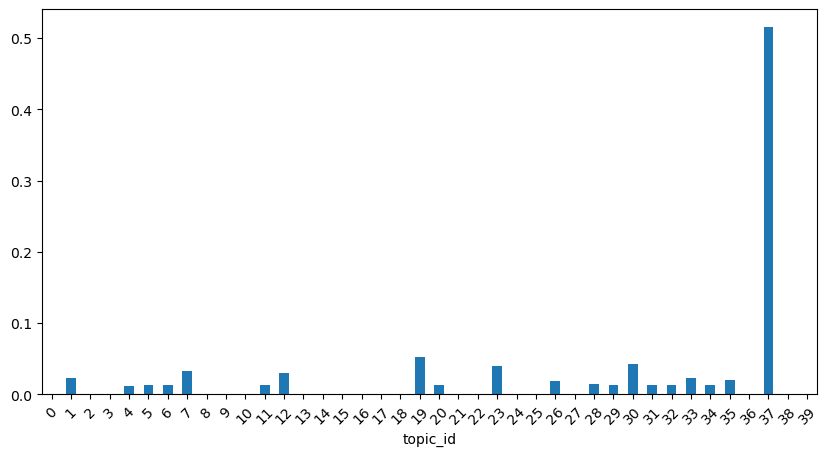

In [17]:
THETA_gs.iloc[7].plot.bar(rot=45, figsize=(10,5));

# Topic Coherence 

Topic coherence measures **the degree of semantic similarity between high-scoring words in the topic**. 

These measures help in distinguishing between topics that are semantically interpretable and topics that are artifacts of the statistical model.


A coherent topic will have high-scoring words that are semantically related, indicating that the topic is likely to be meaningful.

UMass topic coherence is based on document co-occurrence frequencies. A high score suggests that the top words in a topic frequently occur together in documents.

This is related to mutual information.

U_mass topic coherence, a measure of topic interpretability, is calculated by averaging the log-probability of word pairs within a topic, where higher values indicate better topic coherence.

In [54]:
# model.top_topics?

In [55]:
top_topics = model.top_topics(corpus)

Each element in the list is a pair of a topic representation and its coherence score. Topic representations are distributions of words, represented as a list of pairs of word IDs and their probabilities.

In [56]:
top_topics[1]

([(0.1128343, 'have'),
  (0.06784708, 'me'),
  (0.062586136, 'do'),
  (0.05485318, 'it'),
  (0.042318266, 'be'),
  (0.039685134, 'see'),
  (0.039231982, 'you'),
  (0.037338976, 'say'),
  (0.035482682, 'know'),
  (0.03428295, 'am'),
  (0.03068339, 'come'),
  (0.030201435, 'go'),
  (0.030108932, 'think'),
  (0.023332397, 'i'),
  (0.019496664, 'so'),
  (0.018712157, 'tell'),
  (0.017202342, 'but'),
  (0.015885165, 'thing'),
  (0.012524299, 'again'),
  (0.012279743, 'indeed')],
 -2.408705895581346)

In [57]:
TOPICS = pd.DataFrame(
    [(i, j, topic[1], *reversed(term_pair)) for i, topic in enumerate(top_topics) for j, term_pair in enumerate(topic[0])], 
    columns=['topic_id', 'term_rank', 'll', 'term_str', 'term_weight']).set_index(['topic_id','term_rank'])\
    .term_str.unstack().apply(lambda x: ' '.join(x), axis=1).to_frame('top_terms')

In [58]:
TOPICS['coherence'] = pd.DataFrame(top_topics)[1]

In [67]:
TOPICS.sort_values('coherence', ascending=False)

,top_terms,coherence,perplexity
topic_id,,,
0,was had be were been him time being have did m...,-2.037536,4.105438
1,have me do it be see you say know am come go t...,-2.408706,5.309978
2,is man has then let cried take there here life...,-3.330908,10.062436
3,hour means present evening object answer party...,-3.455824,10.972526
4,hand round head side water hands looking turne...,-3.547506,11.692455
5,air moment stood boat looked sight door fell f...,-4.425773,21.492672
6,light lay view thoughts ground aspect scene tr...,-4.877615,29.397362
7,eyes words sat entered spoke towards glance co...,-4.882852,29.504270
8,does seem nature world live need cast hint ano...,-5.301780,39.445251


Recall the perplexity is just the exponentation of negative log probability.

In [63]:
TOPICS['perplexity'] = np.exp2(-TOPICS.coherence)

In [64]:
TOPICS

,top_terms,coherence,perplexity
topic_id,,,
0,was had be were been him time being have did m...,-2.037536,4.105438
1,have me do it be see you say know am come go t...,-2.408706,5.309978
2,is man has then let cried take there here life...,-3.330908,10.062436
3,hour means present evening object answer party...,-3.455824,10.972526
4,hand round head side water hands looking turne...,-3.547506,11.692455
5,air moment stood boat looked sight door fell f...,-4.425773,21.492672
6,light lay view thoughts ground aspect scene tr...,-4.877615,29.397362
7,eyes words sat entered spoke towards glance co...,-4.882852,29.504270
8,does seem nature world live need cast hint ano...,-5.301780,39.445251


<Axes: xlabel='coherence', ylabel='perplexity'>

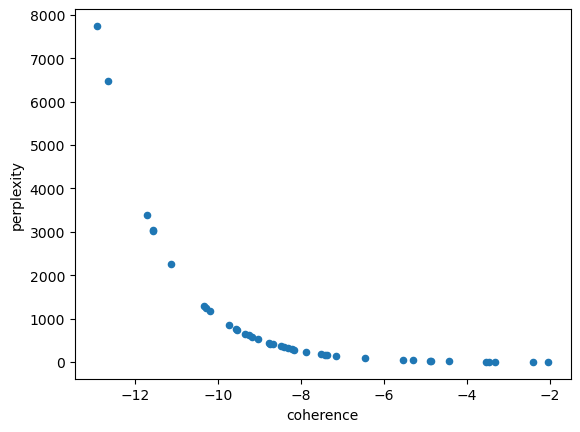

In [66]:
TOPICS.plot.scatter('coherence','perplexity')

Average topic coherence for the model itself is just the sum of topic coherences of all topics, divided by the number of topics. 

In [65]:
TOPICS.coherence.mean()

-7.9883839736228

**QUESTION: Does co-ocurrence imply semantic similarity?**